🐋 **Whale Categorization Playground**

**Fecha:** 6 de julio de 2025  
**Autores:**

Este notebook representa un primer acercamiento para abordar el reto de la competencia **Whale Categorization Playground** en Kaggle. El objetivo principal es aplicar técnicas de **aprendizaje automático supervisado y/o no supervisado** para identificar individuos de ballenas a partir de imágenes de sus aletas caudales, contribuyendo así a la mejora de procesos automáticos de reconocimiento e identificación animal.

Se emplearán diversas estrategias para la preparación, exploración y modelado de los datos, así como la evaluación de resultados bajo la métrica oficial de la competencia.

---

🟢 **Objetivos:**

- Cargar y explorar los datos disponibles.
- Preprocesar las imágenes y datos asociados (normalización, aumentos, limpieza, etc.).
- Implementar modelos de clasificación y/o metric learning (CNN, transfer learning, etc.).
- Evaluar y analizar los resultados obtenidos.
- Generar predicciones para la competencia y preparar el archivo de submission.


## Importar librerías

In [ ]:
!pip install scikit-image
!pip install keras
!pip install tensorflow
!pip install opencv-python
!pip install tqdm



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Dante\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Dante\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Dante\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Dante\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Dante\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage


from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D


%matplotlib inline


## Exploración de datos .csv

In [ ]:
# Cargar el archivo CSV en un DataFrame
train_data = pd.read_csv('train.csv')

# Ver las primeras filas
print(train_data.head())

          Image         Id
0  00022e1a.jpg  w_e15442c
1  000466c4.jpg  w_1287fbc
2  00087b01.jpg  w_da2efe0
3  001296d5.jpg  w_19e5482
4  0014cfdf.jpg  w_f22f3e3


In [ ]:
# Tamaño de train.cv
len(np.unique(train_data.Id))

4251

In [ ]:
# mirar dato
train_data.iloc[0,0], train_data.iloc[0,1]

('00022e1a.jpg', 'w_e15442c')

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,Image,Id
0,00029b3a.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
1,0003c693.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
2,000bc353.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
3,0010a672.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
4,00119c3f.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46


## Leer los archivos de imagen

In [ ]:
listdir('train')[:10]

NameError: name 'listdir' is not defined

In [ ]:
# Define la ruta base donde se encuentran las imágenes de entrenamiento
img_path = "train"

# Inicializa una lista vacía
y = []
# Inicializa una lista vacía para las rutas completas de las imágenes
file_paths = []

# Calcula el número total de imágenes usando el número de filas del DataFrame train_data
count_images = len(train_data)

# Itera sobre cada fila del DataFrame train_data
for i in range(count_images):
    # Construye la ruta completa de la imagen
    file_paths.append(img_path + "/" + str(train_data.iloc[i][0]))
    # Agrega la etiqueta correspondiente
    y.append(train_data.iloc[i][1])

# Convierte la lista
y = np.array(y)


C:\Users\Dante\AppData\Local\Temp\ipykernel_11232\1074286886.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_paths.append(img_path + "/" + str(train_data.iloc[i][0]))
C:\Users\Dante\AppData\Local\Temp\ipykernel_11232\1074286886.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(train_data.iloc[i][1])


In [ ]:
# Ver los nombres de los 10 primeros
file_paths[:10]

['train/00022e1a.jpg',
 'train/000466c4.jpg',
 'train/00087b01.jpg',
 'train/001296d5.jpg',
 'train/0014cfdf.jpg',
 'train/0025e8c2.jpg',
 'train/0026a8ab.jpg',
 'train/0031c258.jpg',
 'train/0035632e.jpg',
 'train/0037e7d3.jpg']

In [ ]:
y[:10]

array(['w_e15442c', 'w_1287fbc', 'w_da2efe0', 'w_19e5482', 'w_f22f3e3',
       'w_8b1ca89', 'w_eaad6a8', 'new_whale', 'w_3d0bc7a', 'w_50db782'],
      dtype='<U9')

## Mostrar ejemplo de imagen

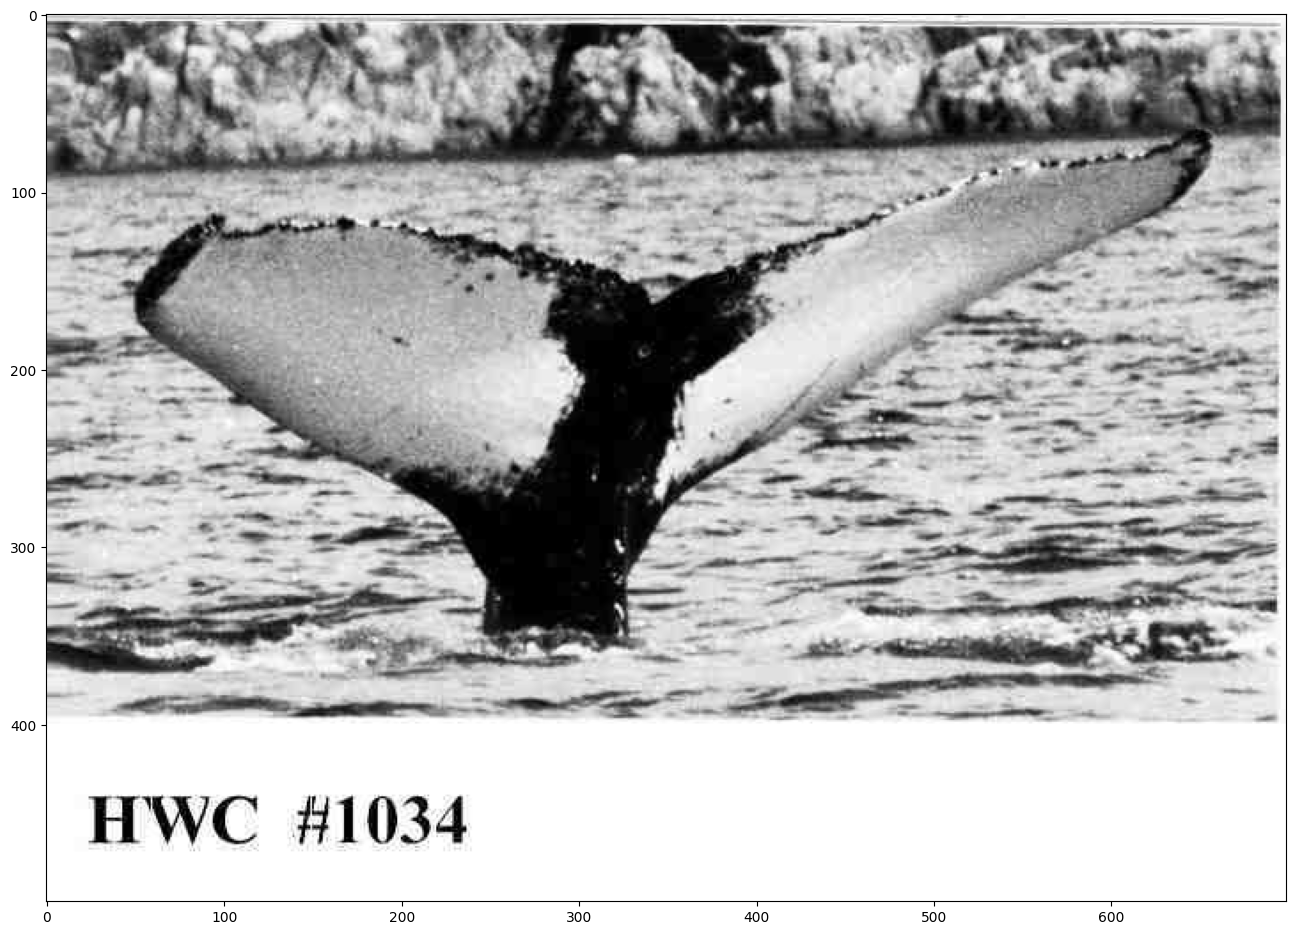

In [ ]:
image = cv2.imread(file_paths[0])
plt.figure(figsize=(16,16))
plt.imshow(image)

In [ ]:
image.shape

(500, 699, 3)

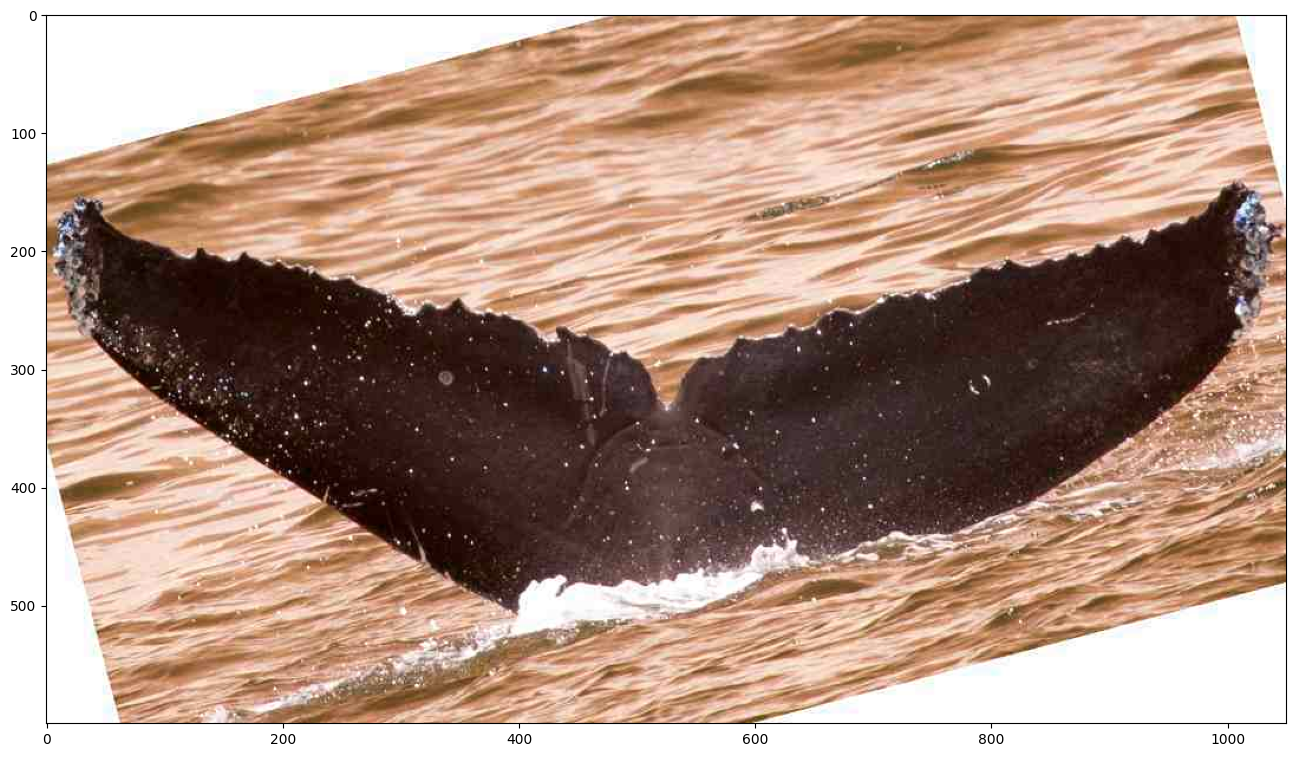

In [ ]:
image = cv2.imread(file_paths[10])
plt.figure(figsize=(16,16))
plt.imshow(image)

## Leer los datos en matrices

In [ ]:
# Redimensionar imagenes
imageSize =100
from tqdm import tqdm

def get_data_and_labels(file_paths, train_data):
    X = []
    y = []
    for i in range(len(file_paths)):
        img_file = cv2.imread(file_paths[i])
        if img_file is not None:
            img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
            img_arr = np.asarray(img_file)
            X.append(img_arr)
            y.append(train_data.Id[i])
    return np.array(X), np.array(y)

X, y = get_data_and_labels(file_paths, train_data)


In [ ]:
print("Cantidad de imágenes cargadas (X):", len(X))
print("Cantidad de etiquetas (y):", len(y))


Cantidad de imágenes cargadas (X): 7340
Cantidad de etiquetas (y): 7340


## Dividir los datos en entrenamiento y validación

In [ ]:
#Split de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [ ]:
# Codificar las etiquetas (label encoding)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()


In [ ]:
# Transforma las etiquetas de entrenamiento y prueba

encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)

In [ ]:
encoder.fit(y_test)
encoded_y_test = encoder.transform(y_test)

In [ ]:
# One-hot encoding para clasificación multiclase (por ejemplo, en Keras)
from keras.utils import to_categorical

y_trainHot = to_categorical(encoded_y_train, num_classes = len(np.unique(train_data.Id)))
y_testHot = to_categorical(encoded_y_test, num_classes = len(np.unique(train_data.Id)))

In [ ]:
y_trainHot[0,np.argmax(y_trainHot[0])]

1.0

In [ ]:
y_trainHot[0,0]


0.0

## Funciones auxiliares

In [ ]:
class MetricsCheckpoint(Callback):
    """Callback que guarda las métricas después de cada epoch."""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath   # Ruta donde se guardarán las métricas
        self.history = {}          # Diccionario para almacenar la historia de métricas

    def on_epoch_end(self, epoch, logs=None):
        # Al final de cada epoch, guarda las métricas del 'logs'
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)  # Guarda el diccionario como archivo .npy

# ---------------------------------------------------------------------

def plotKerasLearningCurve():
    """
    Grafica la curva de aprendizaje (accuracy, loss, etc.) usando el archivo guardado por MetricsCheckpoint.
    """
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True).item()  # Carga el diccionario guardado
    filt = ['acc']  # Puedes cambiarlo a ['acc', 'loss'] para graficar también la pérdida
    for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c='r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x, y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x, y), size=15, color='r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None])
    plt.grid()
    plt.xlabel('Number of epochs')

# ---------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Imprime y grafica la matriz de confusión.
    Parámetros:
        cm: matriz de confusión.
        classes: nombres de las clases.
        normalize: True para normalizar los valores.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# ---------------------------------------------------------------------

def plot_learning_curve(history):
    plt.figure(figsize=(8, 8))
    # Subgráfico 1: accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')

    # Subgráfico 2: loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')



## Construir la red convolucional

In [ ]:
batch_size = 128
num_classes = len(np.unique(train_data.Id))
epochs = 10
img_rows,img_cols=100,100
input_shape = (img_rows, img_cols, 3)
e = 2

In [ ]:
num_classes

4251

In [ ]:
model = Sequential()
model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))
model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))
model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(num_classes, activation='softmax', name='sm'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv0 (Conv2D)                  │ (None, 94, 94, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 94, 94, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool (MaxPooling2D)         │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool (AveragePooling2D)     │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rl (Dense)                      │ (None, 500)            │     7,200,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sm (Dense)                      │ (None, 4251)           │     2,129,751 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353,611 (35.68 MB)

 Trainable params: 9,353,547 (35.68 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
a = X_train
b = y_trainHot
c = X_test
d = y_testHot
epochs = 30

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Entrena el modelo usando el generador de imágenes
history = model.fit(
    datagen.flow(a, b, batch_size=batch_size),
    steps_per_epoch=len(a) // 32,
    epochs=epochs,
    validation_data=(c, d),
    callbacks=[MetricsCheckpoint('logs')]
)



C:\Users\Dante\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 46/183 ━━━━━━━━━━━━━━━━━━━━ 1:06 489ms/step - accuracy: 0.0622 - loss: 8.3995

C:\Users\Dante\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


183/183 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.0726 - loss: 8.2840 - val_accuracy: 0.0865 - val_loss: 8.1870
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.0855 - loss: 7.9273 - val_accuracy: 0.0865 - val_loss: 8.1077
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.0865 - loss: 7.7945 - val_accuracy: 0.0865 - val_loss: 8.1326
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.0867 - loss: 7.7003 - val_accuracy: 0.0865 - val_loss: 8.0270
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.0863 - loss: 7.6329 - val_accuracy: 0.0865 - val_loss: 8.0723
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.0864 - loss: 7.5787 - val_accuracy: 0.0865 - val_loss: 8.0347
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.0861 - loss: 7.4906 - val_accuracy: 0.0865 - val_loss: 8.0450
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.0871 - loss: 7.4771 - val

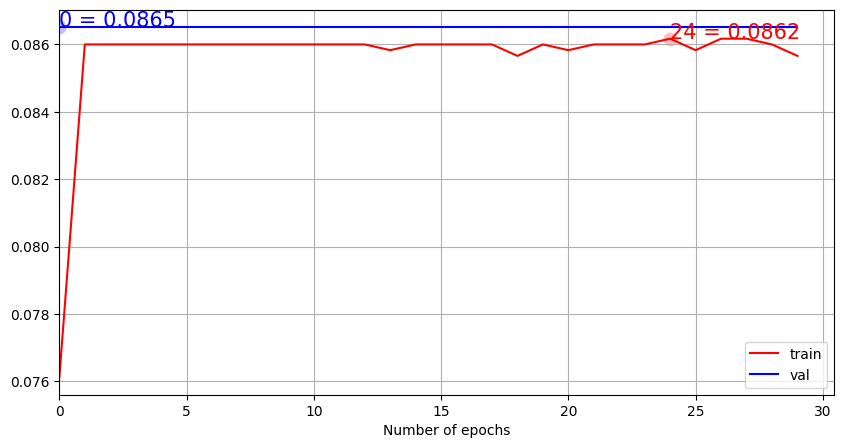

In [ ]:
plotKerasLearningCurve()
plt.show()


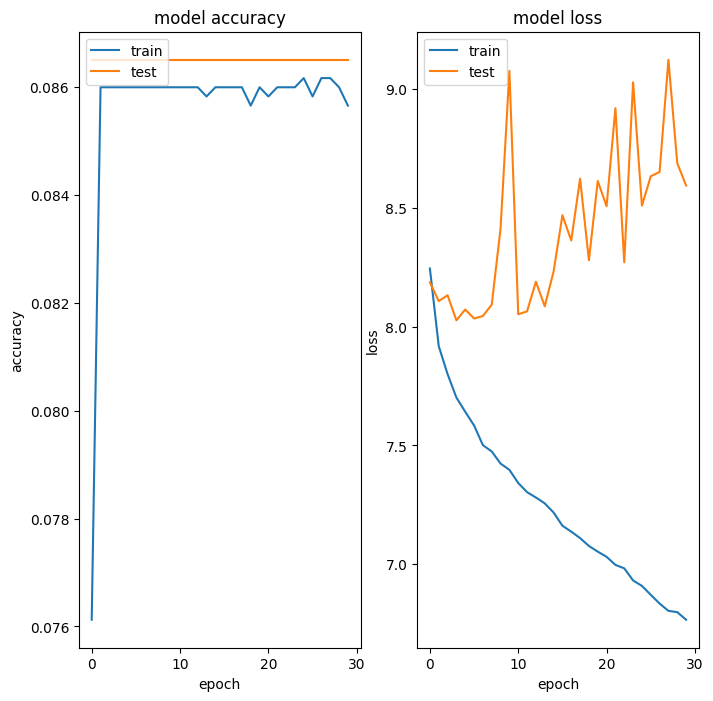

In [ ]:
plot_learning_curve(history)
plt.show()